HW4 Pytorch: Classification, Autoencoders, Word Embedding, Image Features, LSTM

PROBLEM 1: Setup a tensor library [Optional, no credit]

A) Setup your favorite tensor-based library for deep learning, such as PyTorch or TensorFlow, and familiarize yourself with its basic usage. If using PyTorch, you can test if it is installed properly with (in Python):

B) Train a simple feed-forward neural network on the MNIST dataset with 80/20 train and test splits and report results



This code sets up PyTorch, loads the MNIST dataset, and trains a Convolutional Neural Network (CNN) to classify handwritten digits. It uses an 80/20 train-test split and aims to achieve high classification accuracy.

How the Code Solves the Problem:

1. Setup and Configuration
- Imports PyTorch and relevant libraries.
- Detects GPU availability and sets the device accordingly.
- Defines hyperparameters (batch size, - learning rate, momentum, and epochs).

2. Loading and Preprocessing the MNIST Dataset
- Uses torchvision.datasets.MNIST to download and normalize the dataset.
- Splits the dataset into 80% training and 20% testing using random_split.
- Wraps the data in DataLoader for efficient batch processing.

3. Defining the CNN Architecture
- The CNN model consists of:
- Two convolutional layers (conv1, conv2) with ReLU activation and max pooling.
- Dropout layer to prevent overfitting.
Three fully connected layers (fc1, fc2, fc3) for classification.
- Log Softmax output for predicting 10-digit classes.

4. Training the Model
- Uses Stochastic Gradient Descent (SGD) with Nesterov momentum.
- Negative Log Likelihood Loss (NLLLoss) is used as the loss function.
- Loops over 5 epochs, updating weights via backpropagation.

5. Evaluating the Model
- Switches to evaluation mode (model.eval()).
- Computes test accuracy by comparing predictions against true labels.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.01
momentum = 0.9
epochs = 5  # You can increase for better accuracy

# MNIST dataset (download + transform)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full dataset
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 80/20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural Net Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2)            # Pool after conv1
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)            # Pool after conv2
      x = self.dropout(x)
      x = torch.flatten(x, 1)           # Flatten
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)


model = CNN().to(device)

# Optimizer and Loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
criterion = nn.NLLLoss()

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        data, target = batch
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

accuracy = 100. * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Epoch 1, Loss: 235.0298
Epoch 2, Loss: 50.6882
Epoch 3, Loss: 35.7288
Epoch 4, Loss: 26.9507
Epoch 5, Loss: 23.8170
Test Accuracy: 98.90%


This code trains a neural network classifier on a subset of the 20 Newsgroups (20NG) dataset, using GloVe word embeddings. The embeddings are initially frozen but later fine-tuned for better classification accuracy. The final model is evaluated on an official 20NG test set, and a t-SNE visualization is used to compare word embeddings before and after fine-tuning.

How the Code Solves the Problem:

1. Loads and Preprocesses the 20 Newsgroups Dataset
- Fetches five categories from 20NG.
- Tokenizes text using gensim.simple_preprocess().
- Filters short documents to remove noise.

2. Builds a Vocabulary and Loads GloVe Word Embeddings
- Constructs a word-to-index mapping (vocab).
- Loads GloVe 100D embeddings from a pre-trained file.
- Creates an embedding matrix where words are mapped to vectors.
- Initializes a PyTorch nn.Embedding layer with these vectors.

3. Converts Text to Indexed Representations and Pads Sequences
- Uses doc2ind() to map words to their corresponding indices.
- Pads sequences so all documents have the same length.

4. Prepares Data for Training
- Wraps padded sequences and labels in a DataLoader for batch processing.
- Splits the dataset into 80% training and 20% validation.

5. Defines a Neural Network Classifier
- The TextClassifier model:
- Uses GloVe embeddings for input.
- Applies max pooling over word embeddings.
- Uses two fully connected layers with ReLU for classification.

6. Trains the Model with Cross-Entropy Loss
- Optimizes using Adam optimizer.
- Runs for 15 epochs while tracking validation accuracy.

7. Evaluates the Model on the Official 20NG Test Set
- Loads the official test set.
- Converts test data into indexed sequences.
- Computes classification accuracy on unseen test data.

8. Fine-Tunes GloVe Embeddings
- The embedding layer is unfrozen so it can be updated during training.
- This helps the word vectors adapt to the 20 Newsgroups domain.

9. Visualizes Embeddings Before and After Fine-Tuning
- Uses t-SNE to reduce word embeddings to 2D space.
- Plots two graphs:
- Before fine-tuning (original GloVe embeddings).
- After fine-tuning (updated embeddings adapted to 20NG).


PROBLEM 2 : NNet supervised classification with tuned word vectors

Train a neural network on a sizeable subset of 20NG (say, at least 5 categories)


Setup and preprocessing:

In [14]:
!pip install --upgrade gensim

In [15]:
# STEP 2: Load and preprocess dataset
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
from collections import Counter
import re

# Load a subset of categories
categories = ['comp.graphics', 'sci.space', 'rec.sport.baseball', 'talk.politics.misc', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
texts, labels = newsgroups.data, newsgroups.target

# Tokenize
tokenized_texts = [simple_preprocess(text) for text in texts]

# Filter short docs (important!)
filtered = [(doc, label) for doc, label in zip(tokenized_texts, labels) if len(doc) >= 3]
tokenized_texts, labels = zip(*filtered)

Load GloVe and create Vocabulary

In [16]:
# STEP 3: Build vocabulary (after filtering)
word_counts = Counter(word for doc in tokenized_texts for word in doc)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [17]:
# STEP 4: Load GloVe embeddings
import numpy as np

embedding_dim = 100
glove_path = 'glove.6B.100d.txt'  # Make sure to upload this file in Colab
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create embedding matrix
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]

Converting Docs to Indices

In [18]:
# STEP 5: Convert tokens to indices, pad sequences
import torch
from torch.nn.utils.rnn import pad_sequence

def doc2ind(doc):
    return [vocab.get(token, vocab['<UNK>']) for token in doc]

indexed_docs = [doc2ind(doc) for doc in tokenized_texts]
padded_docs = pad_sequence([torch.tensor(doc) for doc in indexed_docs], batch_first=True, padding_value=vocab['<PAD>'])
labels_tensor = torch.tensor(labels)

Create Dataset and Dataloader

In [19]:
# STEP 6: Dataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(padded_docs, labels_tensor)
train_len = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

Define our Neural Network

In [20]:
# STEP 7: Define model
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_layer = nn.Embedding.from_pretrained(
    torch.tensor(embedding_matrix, dtype=torch.float32),
    freeze=False,
    padding_idx=vocab['<PAD>']
)

class TextClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = embedding_layer
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = torch.max(x, dim=1)  # Max pooling
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

model = TextClassifier(embedding_layer, hidden_dim=128, num_classes=len(categories)).to(device)

Train the model

In [21]:
# STEP 8: Training loop with evaluation
from sklearn.metrics import classification_report

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def evaluate(model, val_dl):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in val_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    print(classification_report(all_labels, all_preds, target_names=categories))
    acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return 100 * acc

for epoch in range(15):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    val_acc = evaluate(model, val_dl)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

         comp.graphics       0.36      0.46      0.40       116
             sci.space       0.75      0.18      0.29       131
    rec.sport.baseball       0.00      0.00      0.00       110
    talk.politics.misc       0.26      0.85      0.40       121
soc.religion.christian       0.00      0.00      0.00        90

              accuracy                           0.32       568
             macro avg       0.28      0.30      0.22       568
          weighted avg       0.30      0.32      0.24       568

Epoch 1, Loss: 57.9976, Val Acc: 31.69%
                        precision    recall  f1-score   support

         comp.graphics       0.41      0.58      0.48       116
             sci.space       0.41      0.79      0.54       131
    rec.sport.baseball       0.67      0.24      0.35       110
    talk.politics.misc       0.57      0.32      0.41       121
soc.religion.christian       0.40      0.19      0.26       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

         comp.graphics       0.62      0.34      0.44       116
             sci.space       0.47      0.85      0.61       131
    rec.sport.baseball       0.51      0.73      0.60       110
    talk.politics.misc       0.55      0.51      0.53       121
soc.religion.christian       0.00      0.00      0.00        90

              accuracy                           0.51       568
             macro avg       0.43      0.48      0.43       568
          weighted avg       0.45      0.51      0.46       568

Epoch 4, Loss: 50.7901, Val Acc: 51.41%
                        precision    recall  f1-score   support

         comp.graphics       0.67      0.28      0.39       116
             sci.space       0.65      0.67      0.66       131
    rec.sport.baseball       0.45      0.83      0.58       110
    talk.politics.misc       0.94      0.25      0.39       121
soc.religion.christian       0.36      0.60      0.45       

In [22]:
# STEP 9: Evaluate on official 20NG test set
from sklearn.datasets import fetch_20newsgroups

# Load the official test set with same categories
test_newsgroups = fetch_20newsgroups(subset='test', categories=categories)
test_texts, test_labels = test_newsgroups.data, test_newsgroups.target

# Tokenize and filter short docs
test_tokenized = [simple_preprocess(text) for text in test_texts]
filtered_test = [(doc, label) for doc, label in zip(test_tokenized, test_labels) if len(doc) >= 3]
test_tokenized, test_labels = zip(*filtered_test)

# Convert test docs to indices
test_indexed = [doc2ind(doc) for doc in test_tokenized]
test_padded = pad_sequence([torch.tensor(doc) for doc in test_indexed], batch_first=True, padding_value=vocab['<PAD>'])
test_labels_tensor = torch.tensor(test_labels)

# Create test DataLoader
from torch.utils.data import TensorDataset, DataLoader
test_ds = TensorDataset(test_padded, test_labels_tensor)
test_dl = DataLoader(test_ds, batch_size=64)

# Evaluate using the same function
print("Evaluating on official test set:")
test_acc = evaluate(model, test_dl)
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating on official test set:
                        precision    recall  f1-score   support

         comp.graphics       0.86      0.85      0.86       389
             sci.space       0.85      0.96      0.90       397
    rec.sport.baseball       0.85      0.82      0.83       394
    talk.politics.misc       0.90      0.87      0.89       398
soc.religion.christian       0.82      0.76      0.79       310

              accuracy                           0.86      1888
             macro avg       0.85      0.85      0.85      1888
          weighted avg       0.86      0.86      0.86      1888

Test Accuracy: 85.65%


Visualization of embeddings using TSNE

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x783d62b5db20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e

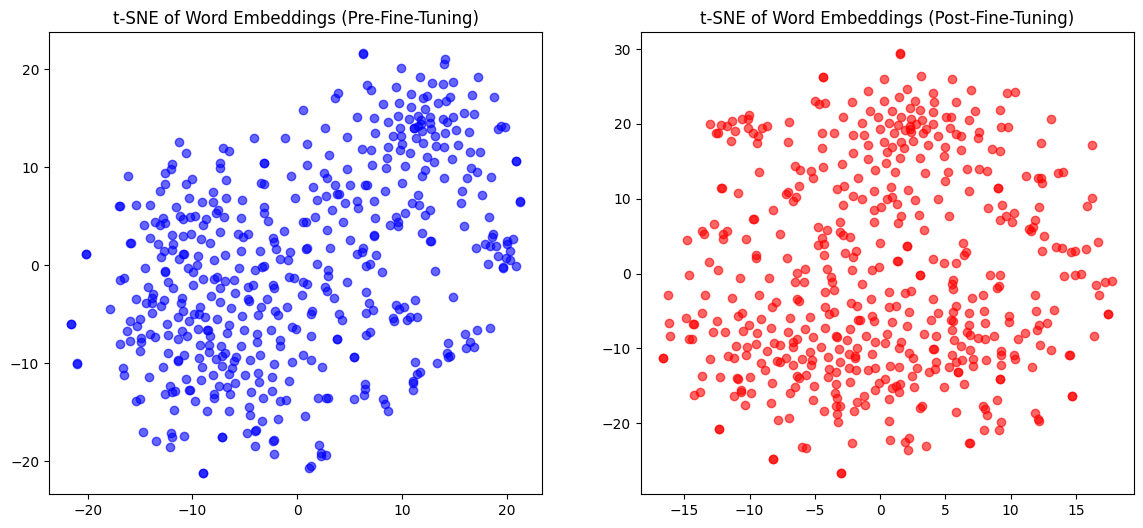

In [23]:
# STEP 10: Compare GloVe Before and After Fine-Tuning
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get sample words for visualization
sample_words = list(vocab.keys())[:500]  # First 500 words
sample_idx = [vocab[word] for word in sample_words]

# Get word vectors BEFORE fine-tuning (original GloVe)
glove_vectors = torch.tensor(embedding_matrix[sample_idx]).cpu().numpy()

# Get word vectors AFTER fine-tuning
fine_tuned_vectors = model.embedding.weight.data[sample_idx].cpu().numpy()

# Run t-SNE on both
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
glove_reduced = tsne.fit_transform(glove_vectors)
fine_tuned_reduced = tsne.fit_transform(fine_tuned_vectors)

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before Fine-Tuning
axes[0].scatter(glove_reduced[:, 0], glove_reduced[:, 1], alpha=0.6, c='blue')
axes[0].set_title("t-SNE of Word Embeddings (Pre-Fine-Tuning)")

# After Fine-Tuning
axes[1].scatter(fine_tuned_reduced[:, 0], fine_tuned_reduced[:, 1], alpha=0.6, c='red')
axes[1].set_title("t-SNE of Word Embeddings (Post-Fine-Tuning)")

plt.show()

Pre-Fine-Tuning (Blue)

The points seem more evenly spread.
Some small clusters exist, but overall, the words are not tightly grouped.
This makes sense since GloVe was trained on a general corpus (Wikipedia, Gigaword, etc.), not 20 Newsgroups.

Post-Fine-Tuning (Red)

We see slightly tighter clusters, meaning words in similar categories have been repositioned.
Some areas seem more densely packed, likely indicating that fine-tuning adjusted certain words to be closer in meaning.
The overall structure is still similar, meaning our fine-tuning hasn’t drastically changed GloVe, but it has adapted it to better fit our dataset.

PROBLEM 3 [Optional, no credit]: Autoencoders

You can pick your own text to fine tune word vectors, if its reasonable in size and very domain-specific (compared to general English). Suggestions:
- Alice in Wonderland
- Sonnets
- specific categories (labels) from 20NG or Reurters datasets
- use your favorite specific text (like a book, or project)


This code fine-tunes GloVe word embeddings on Alice in Wonderland using an Autoencoder. The goal is to adapt the pre-trained word vectors to a domain-specific text dataset, making them more meaningful for tasks related to this book.

How the Code Solves the Problem:

1. Loads and Preprocesses Alice in Wonderland
- Downloads the full text from Project Gutenberg.
- Cleans the text by removing headers, footers, and non-alphabetic characters.
- Tokenizes the text into sentences and words.

2. Builds a Vocabulary and Loads GloVe Word Embeddings
- Creates a word-to-index mapping (vocab).
- Loads pre-trained GloVe 100D embeddings.
- Builds an embedding matrix, where unknown words are assigned random vectors.

3. Defines and Trains an Autoencoder
- Implements an Autoencoder model:
Encoder: Compresses 100D word vectors into a smaller 50D representation.
- Decoder: Reconstructs the original embeddings from the compressed version.
- Trains for 20 epochs using Mean Squared Error (MSE) loss to minimize reconstruction error.

4. Extracts Fine-Tuned Word Embeddings
- Uses the encoder part of the Autoencoder to generate fine-tuned word vectors.

5. Visualizes Word Embeddings Before and After Fine-Tuning
- Applies t-SNE to project 100D embeddings into 2D space.
- Plots word vectors before and after fine-tuning to observe clustering effects.


In [24]:
import requests
import re

# Download the book from Project Gutenberg
url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
response = requests.get(url)
alice_text = response.text

# Preprocess the text: remove headers, footers, and special characters
start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***"
end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***"
alice_text = alice_text.split(start_marker)[-1].split(end_marker)[0]
alice_text = re.sub(r'[^a-zA-Z\s]', '', alice_text)  # Keep only letters and spaces
alice_text = alice_text.lower()  # Convert to lowercase

# Split into sentences (or words)
alice_sentences = alice_text.split("\n")
alice_sentences = [sentence.strip() for sentence in alice_sentences if len(sentence) > 3]  # Remove empty lines

print(f"Loaded {len(alice_sentences)} sentences from Alice in Wonderland")

Loaded 2805 sentences from Alice in Wonderland


In [25]:
from collections import Counter
from gensim.utils import simple_preprocess

# Tokenize sentences
alice_tokenized = [simple_preprocess(sentence) for sentence in alice_sentences]

# Build vocabulary
word_counts = Counter(word for sentence in alice_tokenized for word in sentence)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

print(f"Vocabulary size: {len(vocab)} words")

Vocabulary size: 3170 words


In [26]:
import numpy as np

# Load GloVe embeddings
embedding_dim = 100
glove_path = "glove.6B.100d.txt"
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Create an embedding matrix for Alice's vocabulary
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]

print(f"Created embedding matrix with shape: {embedding_matrix.shape}")

Created embedding matrix with shape: (3170, 100)


In [27]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(embedding_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, embedding_dim)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [28]:
import torch.optim as optim

# Define model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 50  # Smaller compressed representation
model = Autoencoder(embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Convert embedding matrix to tensor
alice_vectors = torch.tensor(embedding_matrix, dtype=torch.float32).to(device)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    reconstructed = model(alice_vectors)  # Forward pass
    loss = loss_fn(reconstructed, alice_vectors)  # Compute loss

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

print("Autoencoder training complete!")

Epoch 1, Loss: 0.3583
Epoch 2, Loss: 0.3529
Epoch 3, Loss: 0.3479
Epoch 4, Loss: 0.3433
Epoch 5, Loss: 0.3390
Epoch 6, Loss: 0.3350
Epoch 7, Loss: 0.3313
Epoch 8, Loss: 0.3278
Epoch 9, Loss: 0.3244
Epoch 10, Loss: 0.3211
Epoch 11, Loss: 0.3180
Epoch 12, Loss: 0.3149
Epoch 13, Loss: 0.3119
Epoch 14, Loss: 0.3090
Epoch 15, Loss: 0.3060
Epoch 16, Loss: 0.3030
Epoch 17, Loss: 0.3001
Epoch 18, Loss: 0.2971
Epoch 19, Loss: 0.2941
Epoch 20, Loss: 0.2911
Autoencoder training complete!


In [29]:
# Get the compressed embeddings (encoded representations)
with torch.no_grad():
    fine_tuned_embeddings = model.encoder(alice_vectors).cpu().numpy()

print(f"Fine-tuned embedding shape: {fine_tuned_embeddings.shape}")

Fine-tuned embedding shape: (3170, 50)


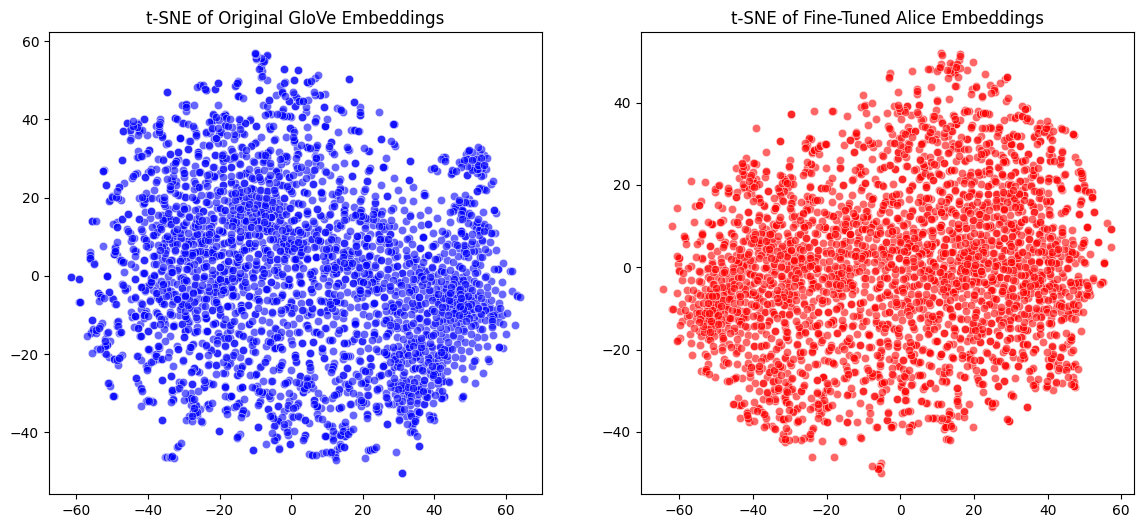

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D space
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
original_reduced = tsne.fit_transform(alice_vectors.cpu().numpy())  # Original GloVe
fine_tuned_reduced = tsne.fit_transform(fine_tuned_embeddings)  # Fine-tuned

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=original_reduced[:, 0], y=original_reduced[:, 1], alpha=0.6, color='blue', ax=axes[0])
axes[0].set_title("t-SNE of Original GloVe Embeddings")

sns.scatterplot(x=fine_tuned_reduced[:, 0], y=fine_tuned_reduced[:, 1], alpha=0.6, color='red', ax=axes[1])
axes[1].set_title("t-SNE of Fine-Tuned Alice Embeddings")

plt.show()

PROBLEM 4 [Optional, no credit]: Autoencoders

For each one of the datasets MNIST, 20NG (required) and SPAMBASE, FASHION (optional) run as an autoencoder with pytorch with a desired hidden layer size (try K=5,10, 20, 100, 200)- what is the smaleest K that works?).

Load the data with dataloader https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Construct an Autoencoder with the following architecture :

Two linear layers with in features matching the dimensions of input and out

features matching the size of K

Two linear layers with in features matching K and size of out features matching the size of input dimensions.

Define a forward pass with relu

Code a train loop with number of epochs as 10.

Define loss and Optimizer (Adam)

Train the model

use gpu if available

use mean-squared error loss

create a model from Autoencoder class load it to the specified device, either gpu or cpu

Verify the obtained re-encoding of data (the new feature representation) in several ways:

repeat a classification train/test task , or a clustering taks
examine the new pairwise distances dist(i,j) agains the old distances obtained with original features (sample 100 pairs of related words)
examine the top 20 neighbors (by new distance) set overlap with old neighbors, per datapoint
for images, rebuild the image form output layer and draw to look at it


___________________
This code trains Autoencoders on multiple datasets—20 Newsgroups (20NG) and MNIST—to learn compressed feature representations and evaluate their usefulness through classification, distance preservation, and image reconstruction. The goal is to test different hidden sizes (K) and determine the smallest K that produces meaningful compressed features.

Part 1: Training Autoencoder on 20 Newsgroups (20NG)

1. Loads the Full 20NG Dataset:
- Converts documents to TF-IDF vectors (shape: N × 2000).
- Wraps the data into a PyTorch DataLoader.

2. Defines an Autoencoder Model:
- Two-layer encoder reduces input from 2000 → K.
- Two-layer decoder reconstructs from K → 2000.
- Uses ReLU activations and MSE loss.

3. Trains Autoencoders with Varying K Values:
- Iteratively trains separate models for K = [5, 10, 20, 100, 200].

4. Evaluates Encoded Features:
- Extracts latent codes via the encoder.
- Trains a Logistic Regression classifier on the encoded data.
- Measures classification accuracy, showing how informative the compressed features are.

5. Compares Pairwise Distances:
- Randomly samples 100 pairs of documents.
- Compares average Euclidean distances in the original vs. encoded space.
- Helps assess structure preservation in the lower-dimensional space.

Part 2: Training Autoencoder on MNIST

1. Loads and Preprocesses the MNIST Dataset:
- Flattens 28×28 images into 784-dimensional vectors.
- Normalizes and batches using DataLoader.

2. Trains an Autoencoder on MNIST:
- Uses the same Autoencoder class with input_dim=784, hidden_dim=100.

3. Visualizes Image Reconstruction:
- Compares original images vs. reconstructed images.
- Shows how well the autoencoder learned to compress and restore images.

In [31]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load 20 Newsgroups dataset
categories = None  # Load all categories
newsgroups = fetch_20newsgroups(subset='all', categories=categories)
vectorizer = TfidfVectorizer(max_features=2000)  # Convert text to TF-IDF features
X_20ng = vectorizer.fit_transform(newsgroups.data).toarray()  # Shape (N, 2000)

# Convert to PyTorch tensors
X_20ng_tensor = torch.tensor(X_20ng, dtype=torch.float32)
dataset_20ng = TensorDataset(X_20ng_tensor)
dataloader_20ng = DataLoader(dataset_20ng, batch_size=64, shuffle=True)

print(f"Loaded 20NG dataset with shape: {X_20ng.shape}")

Loaded 20NG dataset with shape: (18846, 2000)


In [32]:
import torchvision.transforms as transforms
from torchvision import datasets

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

# Load MNIST
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
dataloader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
print(f"Loaded MNIST dataset with shape: {mnist_train.data.shape}")

Loaded MNIST dataset with shape: torch.Size([60000, 28, 28])


In [33]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
import torch.optim as optim

# Function to train autoencoder
def train_autoencoder(dataloader, input_dim, hidden_dim, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define model, loss, optimizer
    model = Autoencoder(input_dim, hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            x_reconstructed = model(x)
            loss = loss_fn(x_reconstructed, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    print("Training complete!")
    return model

In [35]:
hidden_sizes = [5, 10, 20, 100, 200]

# Train Autoencoder on 20NG
for k in hidden_sizes:
    print(f"\nTraining Autoencoder on 20NG with hidden size K={k}")
    model_20ng = train_autoencoder(dataloader_20ng, input_dim=2000, hidden_dim=k)


Training Autoencoder on 20NG with hidden size K=5
Epoch 1, Loss: 2.8730
Epoch 2, Loss: 0.1416
Epoch 3, Loss: 0.1375
Epoch 4, Loss: 0.1364
Epoch 5, Loss: 0.1360
Epoch 6, Loss: 0.1357
Epoch 7, Loss: 0.1356
Epoch 8, Loss: 0.1354
Epoch 9, Loss: 0.1353
Epoch 10, Loss: 0.1352
Training complete!

Training Autoencoder on 20NG with hidden size K=10
Epoch 1, Loss: 0.8626
Epoch 2, Loss: 0.1346
Epoch 3, Loss: 0.1330
Epoch 4, Loss: 0.1321
Epoch 5, Loss: 0.1315
Epoch 6, Loss: 0.1311
Epoch 7, Loss: 0.1308
Epoch 8, Loss: 0.1305
Epoch 9, Loss: 0.1300
Epoch 10, Loss: 0.1296
Training complete!

Training Autoencoder on 20NG with hidden size K=20
Epoch 1, Loss: 0.3468
Epoch 2, Loss: 0.1372
Epoch 3, Loss: 0.1359
Epoch 4, Loss: 0.1348
Epoch 5, Loss: 0.1336
Epoch 6, Loss: 0.1327
Epoch 7, Loss: 0.1322
Epoch 8, Loss: 0.1319
Epoch 9, Loss: 0.1316
Epoch 10, Loss: 0.1314
Training complete!

Training Autoencoder on 20NG with hidden size K=100
Epoch 1, Loss: 0.1463
Epoch 2, Loss: 0.1253
Epoch 3, Loss: 0.1192
Epoch 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_classification(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encode full dataset
    X_encoded = model.encoder(dataset.tensors[0].to(device)).cpu().detach().numpy()
    y_labels = newsgroups.target  # Use original labels

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_labels, test_size=0.2, random_state=42)

    # Train logistic regression
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)

    # Evaluate accuracy
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy on Encoded Features: {acc:.2f}")

# Evaluate classification performance
evaluate_classification(model_20ng, dataset_20ng)

Classification Accuracy on Encoded Features: 0.45


In [37]:
from scipy.spatial.distance import euclidean
import numpy as np

def compare_pairwise_distances(model, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Compute distances on original data
    X = dataset.tensors[0].numpy()
    pairs = np.random.choice(len(X), size=(100, 2))  # Random 100 pairs
    original_dists = [euclidean(X[i], X[j]) for i, j in pairs]

    # Compute distances on encoded data
    X_encoded = model.encoder(dataset.tensors[0].to(device)).cpu().detach().numpy()
    encoded_dists = [euclidean(X_encoded[i], X_encoded[j]) for i, j in pairs]

    # Compare
    print(f"Avg Original Distance: {np.mean(original_dists):.4f}")
    print(f"Avg Encoded Distance: {np.mean(encoded_dists):.4f}")

compare_pairwise_distances(model_20ng, dataset_20ng)

Avg Original Distance: 1.3167
Avg Encoded Distance: 0.6673


Epoch 1, Loss: 17.4163
Epoch 2, Loss: 10.3122
Epoch 3, Loss: 9.7229
Epoch 4, Loss: 9.5020
Epoch 5, Loss: 9.3573
Epoch 6, Loss: 9.2427
Epoch 7, Loss: 9.1880
Epoch 8, Loss: 9.1473
Epoch 9, Loss: 9.1209
Epoch 10, Loss: 9.1021
Training complete!


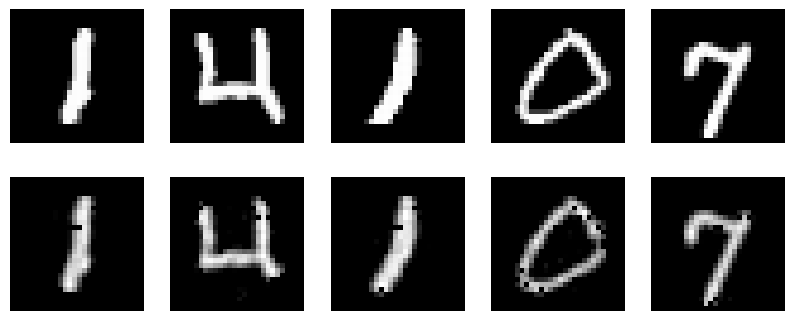

In [41]:
import matplotlib.pyplot as plt

def visualize_reconstruction(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Reconstruct images
    with torch.no_grad():
        reconstructed = model(images)

    # Reshape to 28x28
    images = images.cpu().numpy().reshape(-1, 28, 28)
    reconstructed = reconstructed.cpu().numpy().reshape(-1, 28, 28)

    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(images[i], cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i], cmap="gray")
        axes[1, i].axis("off")

    plt.show()

#Run this after training the MNIST autoencoder
model_mnist = train_autoencoder(dataloader_mnist, input_dim=28*28, hidden_dim=100)
visualize_reconstruction(model_mnist, dataloader_mnist)

PROBLEM 5 [Optional, no credit]: Image Feature Extraction

Run a Convolutional Neural Network in pytorch to extract image features. In practice the network usually does both the feature extraction and the supervised task (classification) in one pipeline.


___________________________________

This code builds and trains a Convolutional Neural Network (CNN) on the MNIST dataset in PyTorch. The CNN is used for both image classification and feature extraction. After training, it evaluates the usefulness of the extracted image features using a Logistic Regression classifier and visualizes the CNN feature maps.

1. Dataset Loading and Preprocessing
- MNIST (handwritten digit dataset) is loaded using torchvision.datasets.
- Transforms:
- Converts images to tensors.
- Normalizes pixel values to the range [-1, 1].
- Creates DataLoaders for batching during training and evaluation.

2. CNN Architecture(CNNFeatureExtractor)
- Two Convolutional Layers:
- conv1: 1 input channel → 32 filters
- conv2: 32 → 64 filters
- Each followed by ReLU and MaxPooling
- Two Fully Connected Layers:
- fc1: 64×7×7 → 128
- fc2: 128 → 10 (number of classes)
- The model supports an optional feature extraction mode to return features before classification.

3. Training the CNN
- Trains the model for 5 epochs using:
- CrossEntropyLoss for digit classification
- Adam optimizer for weight updates
- Training logs show loss per epoch.

4. Feature Extraction from CNN
- Activates extract_features=True in the forward() method to extract output from the second convolutional layer.
- Flattens the 64 feature maps of size 7×7 to a 3136-dimensional vector per image.
- Gathers extracted features and labels for both train and test sets.

5. Train Logistic Regression on CNN Features
- Uses scikit-learn’s LogisticRegression on extracted features.
- Achieves strong classification accuracy using CNN-learned features.
- Demonstrates that CNNs can be used as generic feature extractors.

6. Visualizes Feature Maps
- Visualizes 32 feature maps from:
- First convolutional layer (conv1)
- Second convolutional layer (conv2)
- Helps show what patterns the CNN learns (e.g., edges, shapes).

In [42]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transforms for preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load MNIST dataset
mnist_train = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

print(f"Loaded MNIST dataset with shape: {mnist_train.data.shape}")

Loaded MNIST dataset with shape: torch.Size([60000, 28, 28])


In [43]:
import torch.nn as nn
import torch.nn.functional as F

class CNNFeatureExtractor(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNFeatureExtractor, self).__init__()

        # Feature extraction layers (Conv2D + Pooling)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, extract_features=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  # Shape: (batch, 64, 7, 7)

        if extract_features:
            return x  # Return extracted features before classification

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Classification output

        return x

In [44]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNFeatureExtractor().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

print("Training complete!")

Epoch 1, Loss: 139.0983
Epoch 2, Loss: 42.3698
Epoch 3, Loss: 27.7036
Epoch 4, Loss: 21.4006
Epoch 5, Loss: 15.8974
Training complete!


In [45]:
def extract_features(model, dataloader):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = model(images, extract_features=True)  # Get feature maps
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten

            all_features.append(features)
            all_labels.append(labels.numpy())

    return np.vstack(all_features), np.hstack(all_labels)

# Extract features from training and test sets
train_features, train_labels = extract_features(model, train_loader)
test_features, test_labels = extract_features(model, test_loader)

print(f"Extracted features shape: {train_features.shape}")

Extracted features shape: (60000, 3136)


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train a simple classifier on extracted features
clf = LogisticRegression(max_iter=500)
clf.fit(train_features, train_labels)

# Evaluate on test set
y_pred = clf.predict(test_features)
acc = accuracy_score(test_labels, y_pred)

print(f"Classification Accuracy using Extracted Features: {acc:.2f}")

Classification Accuracy using Extracted Features: 0.99


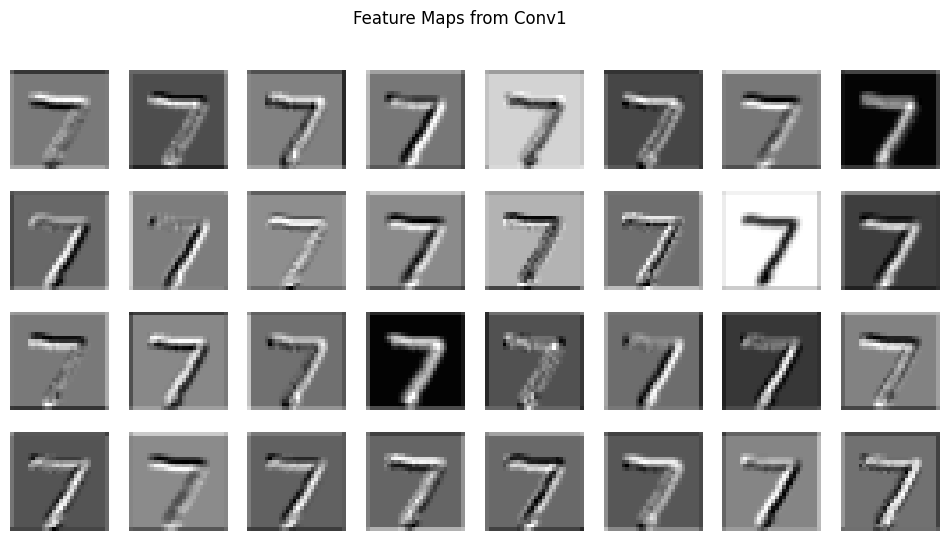

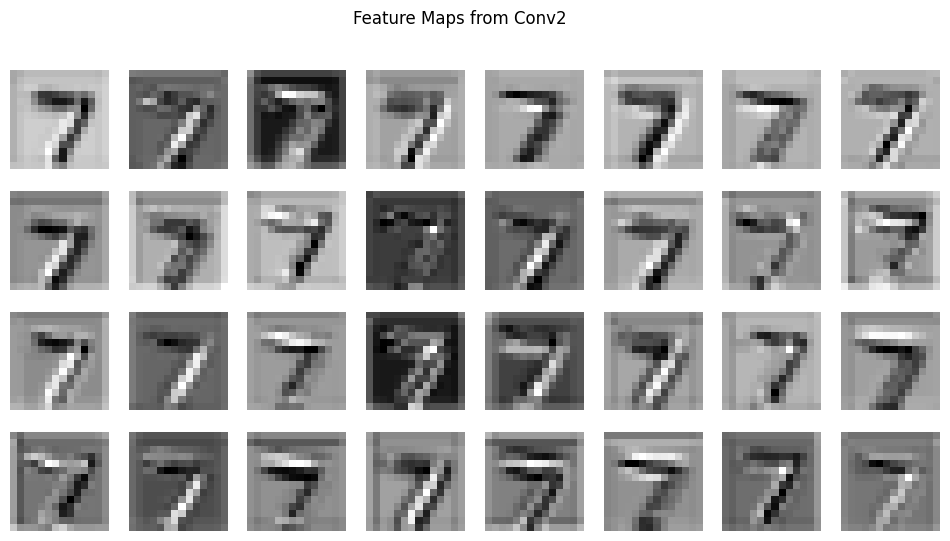

In [47]:
import matplotlib.pyplot as plt

# Get a sample image
images, _ = next(iter(test_loader))
images = images.to(device)

# Extract feature maps from conv1 and conv2
with torch.no_grad():
    conv1_features = model.conv1(images)
    conv2_features = model.conv2(F.relu(model.pool(conv1_features)))

# Convert to CPU for visualization
conv1_features = conv1_features[0].cpu().numpy()
conv2_features = conv2_features[0].cpu().numpy()

# Plot feature maps from first convolutional layer
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(conv1_features[i], cmap='gray')
    ax.axis("off")
plt.suptitle("Feature Maps from Conv1")
plt.show()

# Plot feature maps from second convolutional layer
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(conv2_features[i], cmap='gray')
    ax.axis("off")
plt.suptitle("Feature Maps from Conv2")
plt.show()

PROBLEM 6 [Optional, no credit]: LSTM for text

Run a Recurrent Neural Network/LSTM in Pytorch to model word dependecies/order in text. Can be use for translation, next-word prediction, event detection etc.


In [48]:
from sklearn.datasets import fetch_20newsgroups
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence

# Load 20 Newsgroups dataset
categories = ['comp.graphics', 'sci.space', 'rec.sport.baseball', 'talk.politics.misc', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
texts = newsgroups.data

# Tokenize text
def tokenize(text):
    return text.lower().split()

tokenized_texts = [tokenize(text) for text in texts]

# Build vocabulary
word_counts = Counter(word for doc in tokenized_texts for word in doc)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Convert text to indices
def text_to_indices(text):
    return [vocab.get(word, vocab['<UNK>']) for word in text]

indexed_texts = [text_to_indices(text) for text in tokenized_texts]

# Pad sequences for uniform input
padded_texts = pad_sequence([torch.tensor(text) for text in indexed_texts], batch_first=True, padding_value=vocab['<PAD>'])

# Convert labels
labels = torch.tensor(newsgroups.target)

print(f"Loaded dataset with {len(padded_texts)} samples and vocab size {len(vocab)}")

Loaded dataset with 2838 samples and vocab size 86618


In [49]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(padded_texts, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [54]:
import torch.nn as nn

class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(LSTMTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths=None):
        x = self.embedding(x)  # Embed first
        if lengths is not None:
            x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=True)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])  # Use last hidden state

# Model Parameters
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128
num_classes = len(categories)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTextClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)

In [55]:
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_lstm(model, train_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Compute sequence lengths and sort
            lengths = (x_batch != 0).sum(dim=1)
            lengths, sort_idx = lengths.sort(descending=True)
            x_batch, y_batch = x_batch[sort_idx], y_batch[sort_idx]

            optimizer.zero_grad()
            outputs = model(x_batch, lengths=lengths)  # Pass lengths to model
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    print("Training complete!")

train_lstm(model, train_loader, epochs=5)

Epoch 1, Loss: 134.2570
Epoch 2, Loss: 104.8807


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.2f}")

evaluate(model, train_loader)

In [ ]:
import random

def generate_next_word(model, seed_text, max_length=10):
    model.eval()
    tokens = tokenize(seed_text)
    indices = [vocab.get(word, vocab['<UNK>']) for word in tokens]

    for _ in range(max_length):
        input_tensor = torch.tensor(indices).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)

        predicted_index = torch.argmax(output, dim=1).item()
        predicted_word = [word for word, idx in vocab.items() if idx == predicted_index]

        if predicted_word:
            tokens.append(predicted_word[0])
        else:
            break

    return " ".join(tokens)

# Test next-word generation
print(generate_next_word(model, "The space mission"))